# Librerias

In [2]:
import pandas as pd
import numpy as np
import pyreadstat
import xlwings as xlw
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
from os import listdir
from sklearn.neighbors import KernelDensity
from IPython.display import clear_output
import cufflinks as cf
from unidecode import unidecode
import ipystata
from linearmodels.panel import PanelOLS

sns.set()
# sns.set_style("darkgrid")

cf.go_offline()

# Definiciones

In [8]:
variables_relevantes = ['hogar','numpers','ciudad','secemp','fexp','p02','p03','p10a','area','rama1','grupo1',
                        'p44f','p05a','p05b','p15','p40','p41','p42','p43',
                        'empleo','epobreza','desempleo','desem','pea','pean','secemp','condact','condactn',
                        'ref','ingpc','ingrl','p63','p64b','p65','p66','p67','p68b','p69','p70b','p71b','p72b','p73b','p74b','p76','p77','p77a','p77b','p78','p78a','p78b','p78c']
grupo_edades = pd.IntervalIndex.from_tuples([(0, 20), (21, 30), (31, 40), (41,50), (51,60), (61,200)])
lista_archivos = [s.replace('.sav', '') for s in listdir() if '.sav' in s]
# lista_archivos = ['199512','200612','201812']

df_data = pd.read_excel('data.xlsx','data',3)
df_data['year'] = df_data.year.astype(str)+'12'
df_data.set_index('year', inplace=True)
print(lista_archivos)

df_t, meta_t = pyreadstat.read_sav('201612'+'.sav', metadataonly=True)
provincias = meta_t.variable_value_labels['prov']
lista_amazonia = ['Morona Santiago','Napo','Pastaza','Zamora Chinchipe','Sucumbíos','Orellana']
for k in provincias:
    if provincias[k] in lista_amazonia:
        provincias[k] = 'Amazonía'

provincias[24]='Guayas'
provincias[23]='Pichincha'

print(provincias)

['199512', '199612', '199712', '199812', '199912', '200012', '200112', '200212', '200312', '200412', '200512', '200612', '200712', '200812', '200912', '201012', '201112', '201212', '201312', '201412', '201512', '201612', '201712', '201812', '201912']
{1.0: 'Azuay', 2.0: 'Bolívar', 3.0: 'Cañar', 4.0: 'Carchi', 5.0: 'Cotopaxi', 6.0: 'Chimborazo', 7.0: 'El Oro', 8.0: 'Esmeraldas', 9.0: 'Guayas', 10.0: 'Imbabura', 11.0: 'Loja', 12.0: 'Los Ríos', 13.0: 'Manabí', 14.0: 'Amazonía', 15.0: 'Amazonía', 16.0: 'Amazonía', 17.0: 'Pichincha', 18.0: 'Tungurahua', 19.0: 'Amazonía', 20.0: 'Galapagos', 21.0: 'Amazonía', 22.0: 'Amazonía', 23.0: 'Pichincha', 24.0: 'Guayas', 90.0: 'Zonas no Delimitadas'}


In [3]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if str(value).lower() in [ s.lower() for s in lst2] ] 
    return lst3

def read_meta(file):
    df, meta = pyreadstat.read_sav(file+'.sav', metadataonly=True)
    return meta

def read_columns(file):
    df, meta = pyreadstat.read_sav(file+'.sav', metadataonly=True)
    columns = [s.lower() for s in df.columns]
    return columns

def weight_array(ar, weights):
    zipped = zip(ar, weights)
    weighted = []
    for i in zipped:
        for j in range(i[1]):
            weighted.append(i[0])
    return np.array(weighted)

def weighted_qcut(values, weights, q, **kwargs):
    'Return weighted quantile cuts from a given series, values.'
    if type(q)==int:
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
    order = weights.iloc[values.argsort()].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, labels=False, **kwargs)
    return bins.sort_index()

def weighted_percentile(data, percents, weights=None):
    if weights is None:
        return np.percentile(data, percents)
    ind=np.argsort(data)
    d=data.iloc[ind]
    w=weights.iloc[ind]
    p=1.*w.cumsum()/w.sum()*100
    y=np.interp(percents, p, d)
    return y

def weighted_percentileofscore(values, weights=None, values_sorted=False):
    """ Similar to scipy.percentileofscore, but supports weights.
    :param values: array-like with data.
    :param weights: array-like of the same length as `values`.
    :param values_sorted: bool, if True, then will avoid sorting of initial array.
    :return: numpy.array with percentiles of sorted array.
    """
    values = np.array(values)
    if weights is None:
        weights = np.ones(len(values))
    weights = np.array(weights)

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        weights = weights[sorter]

    total_weight = weights.sum()
    return 100 * np.cumsum(weights) / total_weight

def read_sav(file):
    'Lee el archivo .sav y devuelve un dataframe'  
    df, meta = pyreadstat.read_sav(file+'.sav', metadataonly=False)
    
    # Selecciona solo columnas relevantes:
    df = df[intersection(df.columns, variables_relevantes)]
    
    # Crea columnas con descripción de las variables
    labels = meta.variable_value_labels
    for var in intersection(df.columns, labels.keys()):
        df[var+'_desc'] = df[var].map(labels[var]).fillna(df[var])
    # Lowercase columns
    df.columns = [ str(s).lower() for s in df.columns ]
    cambios = {'edad':'p03' ,'sexo':'p02','nivinst':'p10a'}
    cambios2 = { i+'_desc':v+'_desc' for (i,v) in cambios.items()}
    df.rename(columns = cambios ,inplace=True)
    df.rename(columns =  cambios2,inplace=True)
    print(file,end=' | ')
    return df

# Importación de datos

In [9]:
# if input('Actualizar desde bases .sav (y/n)?').lower() == 'y':
variables_relevantes = ['hogar','numpers','formul','vivienda','persona','ciudad','id_hogar','secemp','fexp','sexo','p02','edad','p03','nivinst','p10a','area','rama1','grupo1',
                        'p44f','p05a','p05b','p15','p40','p41','p42','p43',
                        'empleo','epobreza','desempleo','desem','pea','pean','secemp','condact','condactn',
                        'ref','ingpc','ingrl']
variables_relevantes = ['vivienda','ciudad','sector','zona','panelm','hogar','id_hogar','id_persona','numpers','persona',
                        'fexp','sexo','p02','edad','p03','nivinst','p10a',
                        'condact','ingpc','ingrl']
lista_archivos = [s.replace('.sav', '') for s in listdir() if '.sav' in s]
# lista_archivos = ['199512','199912','200012','200312','200912','201812']

df_data = pd.read_excel('data.xlsx','data',3)
df_data['year'] = df_data.year.astype(str)+'12'
df_data.set_index('year', inplace=True)

if False:    
    df_dict = {file:read_sav(file) for file in lista_archivos}
    meta_dict = {file:read_meta(file) for file in lista_archivos}
    df = pd.concat(df_dict.values(),keys=df_dict.keys(),sort=False).reset_index().rename(columns={"level_0":"year"})
    del df_dict
    df.to_pickle('df_enemdu2')
else:
    df = pd.read_pickle('df_enemdu2')
    meta_dict = {file:read_meta(file) for file in lista_archivos}
clear_output(wait=True)

In [10]:
df_data = pd.read_excel('data.xlsx','data',3)
df_data['year'] = df_data.year.astype(str)+'12'
df_data.set_index('year', inplace=True)

# df.hogar.value_counts(dropna=False)
df['id_hogar'] = np.where(df.id_hogar.isna(),
                          df.ciudad.astype(str)+df.zona.astype(str)+df.sector.astype(str)+df.panelm.astype(str)+df.vivienda.astype(str)+df.hogar.astype(str),
                          df.id_hogar).astype(str)
df['v1'] = 1
df['ingrl'] = np.where(df.ingrl < 0, 0 ,df.ingrl)
df['ingrl'] = np.where(df.ingrl == 999999, np.nan ,df.ingrl)

condact_desc_map = {'OCUPDADOS INDETERMINADOS':'Empleo no clasificado','Ocupados no bien definidos':'Empleo no clasificado','Ocupados no bién definidos':'Empleo no clasificado',
               'OCUPADOS PLENOS':'Empleo Adecuado/Pleno','Ocupados plenos':'Empleo Adecuado/Pleno','SUBEMPLEADOS INVISIBLE':'Subempleo por insuficiencia de tiempo de trabajo',
               'Subempleo invisible':'Subempleo por insuficiencia de tiempo de trabajo','Subocupados invisibles':'Subempleo por insuficiencia de tiempo de trabajo',
               'SUBEMPLEADOS VISIBLE':'Subempleo por insuficiencia de ingresos','Subempleo visible':'Subempleo por insuficiencia de ingresos',
               'Subocupados visibles':'Subempleo por insuficiencia de ingresos','Informales':'Otro empleo no pleno','SUBEMPLEADOS INFORMALES':'Otro empleo no pleno',
               'Subempleo informal':'Otro empleo no pleno','DESOCUPADOS CESANTES':'Desempleo oculto','Desocupados cesantes':'Desempleo oculto',
               'DESOCUPADOS 1A VEZ':'Desempleo abierto','Desocupados 1era vez':'Desempleo abierto','Desocupados primera vez':'Desempleo abierto',
               'INACTIVOS':'Población Económicamente Inactiva','Inactivos':'Población Económicamente Inactiva','MENORES DE EDAD':'Menores de 15 años',
               'Menores de 10 años':'Menores de 15 años','Menores de edad':'Menores de 15 años','INDETERMINADOS':'Población Económicamente Inactiva',
               'Otros inactivos':'Población Económicamente Inactiva'}

df.replace({'condact_desc':condact_desc_map}, inplace=True)

condact_map = {'Menores de 15 años':'0',
               'Empleo Adecuado/Pleno':'1',
               'Subempleo por insuficiencia de tiempo de trabajo':'2',
               'Subempleo por insuficiencia de ingresos':'3',
               'Otro empleo no pleno':'4',
               'Empleo no remunerado':'5',
               'Empleo no clasificado':'6',
               'Desempleo abierto':'7',
               'Desempleo oculto':'8',
               'Población Económicamente Inactiva':'9'}

df['condact'] = df.replace({'condact_desc':condact_map})['condact_desc'].astype(int)
df['pea'] = np.where(df.condact.between(1,8),1,0)
df['desempleo'] = np.where(df.condact.between(7,8),1,0)
df['desempleo2'] = df.desempleo+df.pea

df['npersonas'] = df.groupby(['year','id_hogar'])['v1'].transform('sum')
df['ingsum'] = df.groupby(['year','id_hogar'])['ingrl'].transform('sum')
df['ingpc2'] = df.ingsum / df.npersonas
df['ingpc'] = np.where(df.ingpc,df.ingpc2,df.ingpc)

df['ciudad'] = df['ciudad'].astype('int')
df['provincia'] = df['ciudad'].astype('str').str[:-4].astype('int').map(provincias)

df = df.merge(df_data, how='left', left_on='year', right_index=True)
df['laggedyear'] = (df.year.astype(int).add(-100).astype(str))
df = df.merge(df_data[['sbu','sbu_r', 'sbu_ppp']], how='left', left_on='laggedyear', right_index=True, suffixes=('','_lag'))

df['p_provincial'] = df.groupby(['year','provincia']).apply(lambda x: weighted_qcut(x.ingpc,x.fexp,10)).reset_index([0,1],drop=True)
df['p_nacional'] = df.groupby(['year']).apply(lambda x: weighted_qcut(x.ingpc,x.fexp,10)).reset_index(0,drop=True)

# df['filtro'] = df.groupby(['year'])['ingrl'].transform(np.percentile)
# .apply(lambda x: np.percentile(x.ingrl,[1,99])).reset_index(0,drop=True)

for var in ['ingrl','ingpc']:
    df[var+'_r'] = df[var] / df['tcambio'] / df['ipc']
#     df[var+'_r'] = np.divide(df[var],df['tcambio'] * df['ipc']) * 100
#     df[var+'_ppp'] = df[var]/df['ppp_factor']
    df['fa_'+var] = np.where((df[var] >= df.sbu*0.9) & (df[var] <= df.sbu*1.1),'fa_'+var,'nfa_'+var)
    df['fb_'+var] = np.where(df[var] < df.sbu*0.9,'fb_'+var,'nfb_'+var)
    df['faf_'+var] = np.where((df[var] >= df.sbu_lag) & (df[var] <= df.sbu),'faf_'+var,'nfaf_'+var)


df.columns

Index(['year', 'level_1', 'ciudad', 'zona', 'sector', 'vivienda', 'hogar',
       'persona', 'numpers', 'p03', 'p02', 'p10a', 'condact', 'ingrl', 'fexp',
       'p03_desc', 'p02_desc', 'p10a_desc', 'condact_desc', 'panelm',
       'panelm_desc', 'ingpc', 'id_hogar', 'id_persona', 'ingrl_desc',
       'vivienda_desc', 'hogar_desc', 'v1', 'pea', 'desempleo', 'desempleo2',
       'npersonas', 'ingsum', 'ingpc2', 'provincia', 'ppp_factor', 'ipc',
       'tcambio', 'sbu', 'sbu_r', 'sbu_ppp', 'laggedyear', 'sbu_lag',
       'sbu_r_lag', 'sbu_ppp_lag', 'p_provincial', 'p_nacional', 'ingrl_r',
       'fa_ingrl', 'fb_ingrl', 'faf_ingrl', 'ingpc_r', 'fa_ingpc', 'fb_ingpc',
       'faf_ingpc'],
      dtype='object')

## Ingreso por decil

In [79]:
d1=dict()
for group,d in df.groupby(['year']):
    d1[group] = weighted_percentile(d[df.ingrl>0].ingrl/d[df.ingrl>0].tcambio,range(0,100,10), d[df.ingrl>0].fexp)
    print('Laboral ',group)
    clear_output(wait=True)

df1 = pd.DataFrame.from_dict(d1).T
df1.columns = ['D'+str(i) for i in range(0,10,1)]
df1.index.set_names(['year'], inplace=True)
# df1.to_clipboard()
# df1.iplot()

Laboral  201912


## Desempleo por decil

In [132]:
lista = list()
for decil in range(0,10,1):
    filtro = (df.pea == 1) & (df.p_nacional == decil)
    lista.append(pd.crosstab(df[filtro].year, [df[filtro].p_nacional, df[filtro].desempleo2], df[filtro].fexp, aggfunc=np.sum, normalize='index', dropna=False).droplevel(0,1)[2].rename("desemp"+str(decil+1)))
pd.concat(lista,axis=1).to_clipboard()

# filtro = (df.pea == 1) & (df.p_nacional == 9)
# pd.crosstab(df[filtro].year, [df[filtro].p_nacional, df[filtro].desempleo2], df[filtro].fexp, aggfunc=np.sum, normalize='index', dropna=False).droplevel(0,1)[2]

## Composición laboral por decil

In [12]:
# Composicion laboral por anio
pd.crosstab([df.condact,df.condact_desc],[df.year],df.fexp,aggfunc=np.sum,normalize='columns').to_clipboard()

In [11]:
# Composicion laboral por anio y decil
# lista = list()
# for decil in range(0,10,1):
#     filtro = (df.pea == 1) & (df.p_nacional == decil) #& (df.year=='201912')
#     lista.append(pd.crosstab([df[filtro].condact, df[filtro].condact_desc], [df[filtro].year, df[filtro].p_nacional], df[filtro].fexp, aggfunc=np.sum, normalize='index', dropna=False))

# pd.concat(lista,axis=1)#.to_clipboard()

pd.crosstab([df.condact, df.condact_desc], [df.year, df.p_nacional], df.fexp, aggfunc=np.sum, normalize='columns').to_clipboard()


In [306]:
df.pivot_table('ingpc_r','p_nacional','year',aggfunc='mean').to_clipboard()
# panel

In [52]:
# df[df.year=='201912'].ingpc_r.mean()
# df['filtro'] = df.groupby(['year'])['ingpc'].transform(np.percentile, 50)
df['filtro'] = df.groupby(['year']).apply(lambda x: weighted_percentile(x['ingpc'],50,x['fexp']) )
df.filtro

0          120000.0
1          120000.0
2          120000.0
3          120000.0
4          120000.0
             ...   
1773777       130.0
1773778       130.0
1773779       130.0
1773780       130.0
1773781       130.0
Name: filtro, Length: 1773782, dtype: float64

In [40]:
df.head(50).to_clipboard()

In [241]:
# weighted_percentile(df.ingpc,[.1,.8],weights=df.fexp)
df.sample(1000).to_clipboard()

In [160]:
lista_archivos = ['199512','200012','200312','200912','201812']
lista_archivos >= '200712'

TypeError: '>=' not supported between instances of 'list' and 'str'

In [59]:
# Reemplazo de perdidos --------------------------------
# df['p67'] = np.where(df.p67==999999, 0, df.p67)
# df['p66'] = np.where(df.p66==999999, 0, df.p66)
# df['ingpc'] = np.where(df.ingpc.isna(), 0, df.ingpc)
# print('Dim 1',df.shape)

# Nuevas variables -------------------------------------
a = list(df.columns)

# Crea columna provincia y mapea con el nombre:
df['ciudad'] = df['ciudad'].astype('int')
df['provincia'] = df['ciudad'].astype('str').str[:-4].astype('int').map(provincias)

df = df.merge(df_data, how='left', left_on='year', right_index=True)
df['laggedyear'] = (df.year.astype(int).add(-100).astype(str))
df = df.merge(df_data, how='left', left_on='laggedyear', right_index=True, suffixes=('','_lag'))

df['v1'] = 1
df['grupo_edad'] = pd.cut(df.p03, grupo_edades)
df['petn'] = np.where((df.p03 >= 15) & (df.p03 <= 99) , 1, 0)
df['petn'] = np.where((df.p03 >= 15) & (df.p03 <= 99) , 1, 0)
df['pea'] = np.where(df.condact.between(1,8),1,0)
df['desem78'] = np.where(df.condact.between(7,8),1,0)
df['desem782'] = df.desem78+df.pea

df['informal_ss'] = np.where(np.isin(df.p05a,[1,2,3,4]), 'formal_ss', 'informal_ss') # Informalidad por seguridad social
df['ingrsal'] = df.p66.add(df.p67)
df['ingrcp'] = df.ingrl.add(-df.ingrsal)
df[['ingrsal','ingrcp']] = df[['ingrsal','ingrcp']].fillna(0)
df['p_provincial'] = df.groupby(['year','provincia']).apply(lambda x: weighted_qcut(x.ingpc,x.fexp,10)).reset_index([0,1],drop=True)
df['p_nacional'] = df.groupby(['year']).apply(lambda x: weighted_qcut(x.ingpc,x.fexp,10)).reset_index(0,drop=True)
for var in ['ingrl','ingrsal','ingrcp']:
    df[var+'_r'] = df[var]/df['ipc']*100
    df[var+'_ppp'] = df[var]/df['ppp_factor']
    df['fa_'+var] = np.where((df[var] >= df.sbu*0.9) & (df[var] <= df.sbu*1.1),'fa_'+var,'nfa_'+var)
    df['fb_'+var] = np.where(df[var] < df.sbu*0.9,'fb_'+var,'nfb_'+var)
    df['faf_'+var] = np.where((df[var] >= df.sbu_lag) & (df[var] <= df.sbu),'faf_'+var,'nfaf_'+var)
    
print('Dim 2',df.shape, set(df.columns) - set(a))

# Agrupación de datos

df['p15_desc'] = np.where( np.isin(df.p15_desc,['Mulato','Negro']), 'Afroecuatoriano', df.p15_desc )
df['p15_desc'] = np.where( np.isin(df.p15_desc,['Otro, cual','Montubio']) , 'Indígena', df.p15_desc )

df['p10a_desc'] = np.where( np.isin(df.p10a_desc,['Ninguno', 'Centro de alfabetización']) , 'sin_educacion', df.p10a_desc )
df['p10a_desc'] = np.where( np.isin(df.p10a_desc,['Educación Básica', 'Primaria']) , 'primaria', df.p10a_desc )
df['p10a_desc'] = np.where( np.isin(df.p10a_desc,['Educación  Media', 'Educación Media', 'Secundaria']) , 'secundaria', df.p10a_desc )
df['p10a_desc'] = np.where( np.isin(df.p10a_desc,['Superior Universitario', 'Superior no universitario', 'Post-grado']) , 'terciaria', df.p10a_desc )

df['area_desc'] = np.where(df.area == 1,'Urbano', 'Rural')


# Elimina filas no deseadas -------------------------
a = df.shape[0]

# condition = ((df.provincia != 'Zonas no Delimitadas') & (df.provincia != 'Galapagos')) #& (df.ingrl != 0) & (df.ingrl>0))
# df = df[condition]

print('Dim 3',df.shape,df.shape[0]-a)

# df.head(5)

AttributeError: 'DataFrame' object has no attribute 'p03'

In [23]:
for col in df.columns:
    print(col, end=' ')

year level_1 area ciudad fexp ingrl condact condact_desc area_desc p02 p03 p05a p05b p10a p15 p40 p41 p42 p43 p44f p63 p64b p65 p66 p67 p68b p69 p70b p71b p72b p73b p74b p76 p77a p77b p78 empleo desempleo secemp ingpc epobreza rama1 grupo1 p02_desc p03_desc p05a_desc p05b_desc p10a_desc p15_desc p40_desc p41_desc p42_desc p43_desc p44f_desc p63_desc p64b_desc p65_desc p66_desc p67_desc p68b_desc p69_desc p70b_desc p71b_desc p72b_desc p73b_desc p74b_desc p76_desc p77a_desc p77b_desc p78_desc empleo_desc desempleo_desc secemp_desc ingrl_desc epobreza_desc rama1_desc grupo1_desc p78a p78b p78c p78a_desc p78b_desc p78c_desc p77 p77_desc 

In [ ]:
# xlw.Book('smin.xlsx').sheets('Sheet3').range('A1').value = df.dropna(subset=['ingrl']).sample(10000)
# df[['p43','p43_desc']].drop_duplicates()
# df[['area','area_desc']].drop_duplicates().sort_values('area')

In [ ]:
df_t = df[df.year=='201712']
pd.crosstab([df_t.grupo1,df_t.grupo1_desc],[df_t.year,df_t.rama1_desc.str[0],df_t.p02_desc],df_t.fexp,aggfunc=np.sum).to_clipboard() #.xs('Mujer',axis=1,level=1,drop_level=False)

# Densidades

In [ ]:
%%time
# years = [str(i) for i in list(range(200712,201812,100))]
years = ['200712','201212','201712']
fig, axs = plt.subplots(2,len(years),sharey=True,sharex=True, figsize=(20,7), dpi=200)
colors = ['red','blue','green','navy','orange']
# fig.suptitle('Densidades de ingresos laborales, cuenta propia y salarios')

for i,year in enumerate(years):
    P = 100
    hl = list()
    variables = {'ingrsal_r':'Salarios',
                 'ingrcp_r':'Cuentas Propias',}
#                  'ingrl_r':'Laboral'}
    for var in variables.keys():
        cond = (df[var]>0) & (df['year']==year)
        df_t = df[cond][[var,'fexp']]
        X = np.log(np.array(df_t.iloc[:,0]).reshape(-1, 1))
        S = df_t.iloc[:,1]
        h = X.std()*(4/3/X.size)**(1/10) # Silverman rule of thumb for kernel bandwith
        hl.append(np.round(h,3))
        kde = KernelDensity(bandwidth=h,kernel='epanechnikov').fit(X=X, sample_weight=S)
        x_plot = np.linspace(X.min(), X.max(), P).reshape(-1,1)
        y_plot = np.exp(kde.score_samples(x_plot))
        y_plot_c = np.cumsum(y_plot)/np.cumsum(y_plot)[-1]
        axs[0,i].plot(x_plot,y_plot,label=variables[var])
        axs[1,i].plot(x_plot,y_plot_c,label=variables[var])
        print(year, variables[var])
        clear_output(wait=True)
    
    axs[0,i].axvspan(np.log(df_data.sbu_r[year]*0.90),np.log(df_data.sbu_r[year]*1.10), alpha=0.25, color='grey')
    axs[0,i].axvline(np.log(df_data.sbu_r[year]), label='MW', ls=':', color='black')
    axs[1,i].axvline(np.log(df_data.sbu_r[year]), label='MW', ls=':', color='black')
    
    axs[0,i].set_title(year[0:4]+'\n'+'h='+str(hl),loc='right')
    if i==0:
        axs[0,i].legend()

# plt.xlim((0,1000))

axs[1,0].axhline(0.41, label='MW', ls='--', color='navy', alpha=0.3)
axs[1,1].axhline(0.39, label='MW', ls='--', color='navy', alpha=0.3)
axs[1,2].axhline(0.38, label='MW', ls='--', color='navy', alpha=0.3)

axs[1,0].axhline(0.94, label='MW', ls='--', color='darkorange', alpha=0.3)
axs[1,1].axhline(0.99, label='MW', ls='--', color='darkorange', alpha=0.3)
axs[1,2].axhline(0.99, label='MW', ls='--', color='darkorange', alpha=0.3)

plt.xlim((1,8))
plt.savefig('densidades.png',dpi=300)
plt.show()

In [ ]:
years = enumerate([str(i) for i in list(range(200712,201912,100))])
iss = range(0,13,1)


In [ ]:
# [type(i%2) for i in iss]
# [(int((i-i%2)/2)) for i in iss]
len(years)
(int(len(years)/cols),cols)

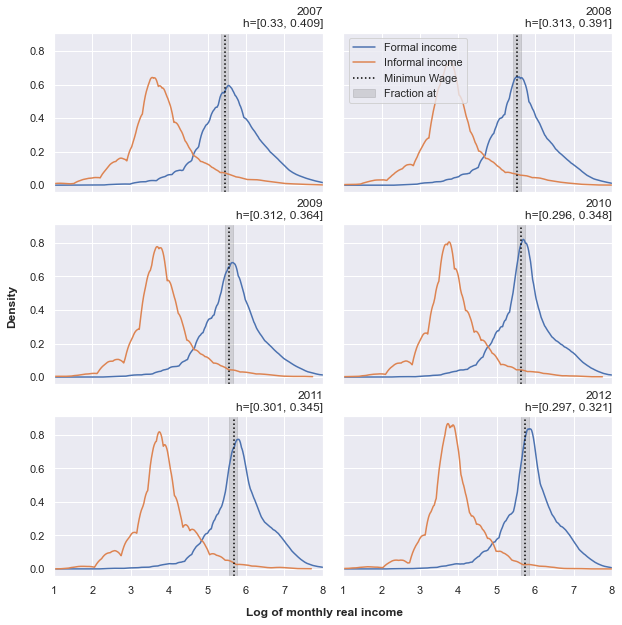

Wall time: 59.7 s


In [5]:
%%time
years = [str(i) for i in list(range(200712,201312,100))]
cols = 2

fig, axs = plt.subplots(int(len(years)/cols),cols,sharey=True,sharex=True,figsize=(10,10), gridspec_kw={'wspace':.075})

colors = ['red','blue','green','navy','orange']
# fig.suptitle('Densidades de ingresos laborales, cuenta propia y salarios')

for i,year in enumerate(years):
    P = 2000
    hl = list()
    variables = {'ingrsal_r':'Formal income',
                 'ingrcp_r':'Informal income',}
#                  'ingrl_r':'Laboral'}
    for var in variables.keys():
        cond = (df[var]>0) & (df['year']==year)
        df_t = df[cond][[var,'fexp']]
        X = np.log(np.array(df_t.iloc[:,0]).reshape(-1, 1))
        S = df_t.iloc[:,1]
        h = X.std()*(4/3/X.size)**(1/10) # Silverman rule of thumb for kernel bandwith
        hl.append(np.round(h,3))
        kde = KernelDensity(bandwidth=h,kernel='epanechnikov').fit(X=X, sample_weight=S)
        x_plot = np.linspace(X.min(), X.max(), P).reshape(-1,1)
        y_plot = np.exp(kde.score_samples(x_plot))
        y_plot_c = np.cumsum(y_plot)/np.cumsum(y_plot)[-1]
        axi = int((i-i%cols)/cols)
        axj = i%2        
        axs[axi,axj].plot(x_plot,y_plot,label=variables[var])
#         axs[1,i].plot(x_plot,y_plot_c,label=variables[var])
        print(year, variables[var])
        clear_output(wait=True)
        
    axs[axi,axj].axvspan(np.log(df_data.sbu_r[year]*0.90),np.log(df_data.sbu_r[year]*1.10), alpha=0.25, color='grey', label='Fraction at')
    axs[axi,axj].axvline(np.log(df_data.sbu_r[year]), label='Minimun Wage', ls=':', color='black')

    axs[axi,axj].set_title(year[0:4]+'\n'+'h='+str(hl),loc='right') #,fontdict = {'fontsize' : 9})
    
fig.text(0.5, 0.07, 'Log of monthly real income', ha='center', fontdict = {'fontsize' : 12,'weight': 'bold'})
fig.text(0.06, 0.5, 'Density', va='center', rotation='vertical', fontdict = {'fontsize' : 12,'weight': 'bold'})
axs[0,1].legend(loc = 'upper left')

# fig.set_xlabel('common xlabel')
# fig.set_ylabel('common ylabel')
# fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center')
# fig.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical')

plt.xlim((1,8))
plt.savefig('densidades1.png',dpi=300,bbox_inches='tight')
plt.show()

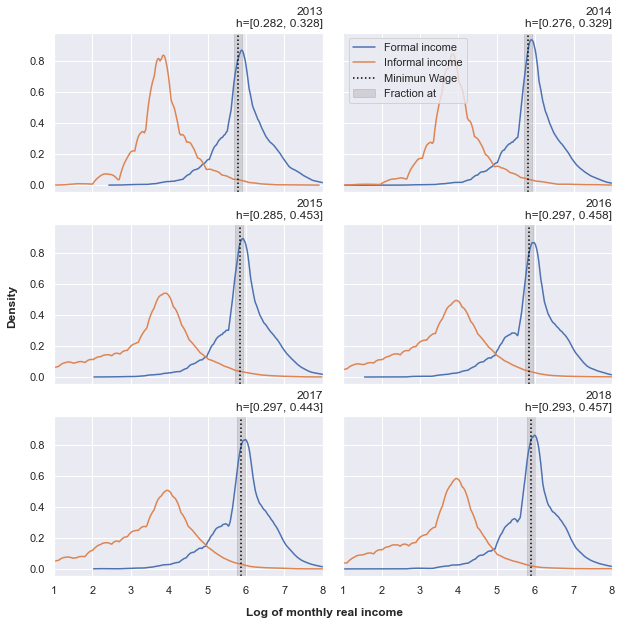

Wall time: 1min 20s


In [6]:
%%time
years = [str(i) for i in list(range(201312,201912,100))]
cols = 2

fig, axs = plt.subplots(int(len(years)/cols),cols,sharey=True,sharex=True,figsize=(10,10), gridspec_kw={'wspace':.075})

colors = ['red','blue','green','navy','orange']
# fig.suptitle('Densidades de ingresos laborales, cuenta propia y salarios')

for i,year in enumerate(years):
    P = 2000
    hl = list()
    variables = {'ingrsal_r':'Formal income',
                 'ingrcp_r':'Informal income',}
#                  'ingrl_r':'Laboral'}
    for var in variables.keys():
        cond = (df[var]>0) & (df['year']==year)
        df_t = df[cond][[var,'fexp']]
        X = np.log(np.array(df_t.iloc[:,0]).reshape(-1, 1))
        S = df_t.iloc[:,1]
        h = X.std()*(4/3/X.size)**(1/10) # Silverman rule of thumb for kernel bandwith
        hl.append(np.round(h,3))
        kde = KernelDensity(bandwidth=h,kernel='epanechnikov').fit(X=X, sample_weight=S)
        x_plot = np.linspace(X.min(), X.max(), P).reshape(-1,1)
        y_plot = np.exp(kde.score_samples(x_plot))
        y_plot_c = np.cumsum(y_plot)/np.cumsum(y_plot)[-1]
        axi = int((i-i%cols)/cols)
        axj = i%2        
        axs[axi,axj].plot(x_plot,y_plot,label=variables[var])
#         axs[1,i].plot(x_plot,y_plot_c,label=variables[var])
        print(year, variables[var])
        clear_output(wait=True)
        
    axs[axi,axj].axvspan(np.log(df_data.sbu_r[year]*0.90),np.log(df_data.sbu_r[year]*1.10), alpha=0.25, color='grey', label='Fraction at')
    axs[axi,axj].axvline(np.log(df_data.sbu_r[year]), label='Minimun Wage', ls=':', color='black')

    axs[axi,axj].set_title(year[0:4]+'\n'+'h='+str(hl),loc='right') #,fontdict = {'fontsize' : 9})
    
fig.text(0.5, 0.07, 'Log of monthly real income', ha='center', fontdict = {'fontsize' : 12,'weight': 'bold'})
fig.text(0.06, 0.5, 'Density', va='center', rotation='vertical', fontdict = {'fontsize' : 12,'weight': 'bold'})
axs[0,1].legend(loc = 'upper left')

# fig.set_xlabel('common xlabel')
# fig.set_ylabel('common ylabel')
# fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center')
# fig.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical')

plt.xlim((1,8))
plt.savefig('densidades2.png',dpi=300,bbox_inches='tight')
plt.show()

# Armado del Panel

In [17]:
d1=dict()
for item in df.groupby(['provincia','year']):
    d1[item[0]] = weighted_percentile(item[1].ingrl_r,range(10,110,10), item[1].fexp)
    print('Laboral ',item[0][1],item[0][0])
    clear_output(wait=True)

panel = pd.DataFrame.from_dict(d1).T
panel.columns = ['lab'+str(i) for i in range(1,11,1)]
panel.index.set_names(['provincia','year'], inplace=True)
list_df = list()

d1=dict()
for item in df[df.ingrsal_r>0].groupby(['provincia','year']):
    d1[item[0]] = weighted_percentile(item[1].ingrsal_r,range(10,110,10), item[1].fexp)
    print('Salarial ',item[0][1],item[0][0])
    clear_output(wait=True)

panel1 = pd.DataFrame.from_dict(d1,).T
panel1.columns = ['sal'+str(i) for i in range(1,11,1)]
panel1.index.set_names(['provincia','year'], inplace=True)
list_df.append(panel1)

d1=dict()
for item in df[df.ingrcp_r>0].groupby(['provincia','year']):
    d1[item[0]] = weighted_percentile(item[1].ingrcp_r,range(10,110,10), item[1].fexp)
    print('Cuenta Propia ',item[0][1],item[0][0])
    clear_output(wait=True)

panel1 = pd.DataFrame.from_dict(d1,).T
panel1.columns = ['cp'+str(i) for i in range(1,11,1)]
panel1.index.set_names(['provincia','year'], inplace=True)
list_df.append(panel1)

list_df.append(df.pivot_table('sbu_r', ['provincia','year'])) # SBU OK
list_df.append(pd.crosstab([df.provincia,df.year],[df.fa_ingrl], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction at ingreso laboral
list_df.append(pd.crosstab([df.provincia,df.year],[df.fa_ingrsal], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction at ingreso salarial
list_df.append(pd.crosstab([df.provincia,df.year],[df.fa_ingrcp], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction at ingreso cuenta propia
list_df.append(pd.crosstab([df.provincia,df.year],[df.fb_ingrl], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction below ingreso laboral
list_df.append(pd.crosstab([df.provincia,df.year],[df.fb_ingrsal], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction below ingreso salarial
list_df.append(pd.crosstab([df.provincia,df.year],[df.fb_ingrcp], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction below ingreso cuenta propia
list_df.append(pd.crosstab([df.provincia,df.year],[df.faf_ingrl], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction affected ingreso laboral
list_df.append(pd.crosstab([df.provincia,df.year],[df.faf_ingrsal], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction affected ingreso salarial
list_df.append(pd.crosstab([df.provincia,df.year],[df.faf_ingrcp], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction affected ingreso cuenta propia

list_df.append(pd.crosstab([df.provincia,df.year],[df.informal_ss], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Informalidad por seguridad social OK
list_df.append(pd.crosstab([df.provincia,df.year],[df.p02_desc], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Sexo OK
list_df.append(pd.crosstab([df.provincia,df.year],[df.p15_desc], normalize='index', dropna=False)) # Etnia OK
list_df.append(pd.crosstab([df.provincia,df.year],[df.p10a_desc], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Nivel de educación OK
list_df.append(pd.crosstab([df.provincia,df.year],[df.area_desc], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Urbano o rural OK
# list_df.append(pd.crosstab([df.provincia,df.year],[df.grupo1_desc], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Industria
list_df.append(pd.crosstab([df.provincia,df.year],[df.rama1_desc.str[0]], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Industria

for item in list_df:
    panel = panel.merge(item, how='left', left_index=True, right_index=True)

for col in [col for col in panel.columns if col.startswith(('lab','sal','cp','sbu'))]:
    panel['l'+col] = np.log(panel[col])
    panel['dl'+col] = panel['l'+col].groupby(level=0).transform(pd.DataFrame.diff)

for col in [col for col in panel.columns if col.startswith(('fa_','fb_','faf_'))]:
    panel['d'+col] = panel[col].groupby(level=0).transform(pd.DataFrame.diff)

# panel.columns = [str(col) for col in panel.columns]
panel.reset_index(inplace=True)
panel.columns = [unidecode(str(col).lower().replace(' ','_')) for col in panel.columns]
panel['year'] = panel.year.str[0:4].astype(int)
panel['provincia'] = panel.provincia.apply(unidecode)
panel = panel[panel.year<2018]
panel.set_index(['provincia','year'], inplace=True)
# panel

for col in panel.columns:
    print(col, end=' ')

lab1 lab2 lab3 lab4 lab5 lab6 lab7 lab8 lab9 lab10 sal1 sal2 sal3 sal4 sal5 sal6 sal7 sal8 sal9 sal10 cp1 cp2 cp3 cp4 cp5 cp6 cp7 cp8 cp9 cp10 sbu_r fa_ingrl nfa_ingrl fa_ingrsal nfa_ingrsal fa_ingrcp nfa_ingrcp fb_ingrl nfb_ingrl fb_ingrsal nfb_ingrsal fb_ingrcp nfb_ingrcp faf_ingrl nfaf_ingrl faf_ingrsal nfaf_ingrsal faf_ingrcp nfaf_ingrcp formal_ss informal_ss hombre mujer afroecuatoriano blanco indigena mestizo primaria secundaria sin_educacion terciaria rural urbano a b c d e f g h i j k l m n o p q r s t u llab1 dllab1 llab2 dllab2 llab3 dllab3 llab4 dllab4 llab5 dllab5 llab6 dllab6 llab7 dllab7 llab8 dllab8 llab9 dllab9 llab10 dllab10 lsal1 dlsal1 lsal2 dlsal2 lsal3 dlsal3 lsal4 dlsal4 lsal5 dlsal5 lsal6 dlsal6 lsal7 dlsal7 lsal8 dlsal8 lsal9 dlsal9 lsal10 dlsal10 lcp1 dlcp1 lcp2 dlcp2 lcp3 dlcp3 lcp4 dlcp4 lcp5 dlcp5 lcp6 dlcp6 lcp7 dlcp7 lcp8 dlcp8 lcp9 dlcp9 lcp10 dlcp10 lsbu_r dlsbu_r dfa_ingrl dfa_ingrsal dfa_ingrcp dfb_ingrl dfb_ingrsal dfb_ingrcp dfaf_ingrl dfaf_ingrsal d

In [22]:
panel

lab1        lab2        lab3        lab4        lab5  \
provincia  year                                                              
Amazonia   2007  50.322251   85.626458  136.246405  189.414450  245.243529   
           2008  62.595666  100.153066  150.229599  200.306132  250.382665   
           2009  48.006611   84.011569  141.619503  180.024792  217.598266   
           2010  58.075491  116.150982  162.611375  216.753996  278.762357   
           2011  57.031872  110.190364  165.285546  220.380728  286.494947   
...                    ...         ...         ...         ...         ...   
Tungurahua 2013  72.102861  139.055517  206.008174  257.510217  327.270414   
           2014  79.488155  149.040291  198.720387  268.272523  337.824659   
           2015  86.500354  144.167257  211.445310  280.057224  340.703676   
           2016  57.028305  123.561327  190.094349  237.617936  323.160393   
           2017  65.493886  133.328302  205.549219  285.703504  357.129380   

                       lab6        lab7        lab8        lab9         lab10  \
provincia  year                                                                 
Amazonia   2007  313.366732  408.739215  544.985620  817.478431  37274.291506   
           2008  325.497465  438.169664  600.918397  826.262796  19404.656565   
           2009  281.626709  354.048757  488.131515  734.345237   6540.900758   
           2010  330.680358  383.530567  546.363070  782.798978   4953.839393   
           2011  363.628202  440.761457  612.343979  984.648207   6060.470032   
...                     ...         ...         ...         ...           ...   
Tungurahua 2013  364.016141  432.617165  561.427673  844.193578  10300.408692   
           2014  391.479163  450.422165  586.225143  894.241743  12916.825180   
           2015  384.446018  461.335222  576.669027  879.744058   9534.261253   
           2016  380.188698  428.662757  551.273612  855.424570  15587.736608   
           2017  412.365390  494.426192  666.641509  952.345012  30189.336887   

                 ...   dlsbu_r  dfa_ingrl  dfa_ingrsal  dfa_ingrcp  dfb_ingrl  \
provincia  year  ...                                                            
Amazonia   2007  ...       NaN        NaN          NaN         NaN        NaN   
           2008  ...  0.077897   0.045046     0.035791    0.006129  -0.007225   
           2009  ...  0.043964  -0.009124    -0.001727   -0.005936   0.071734   
           2010  ...  0.063405   0.016550     0.013099    0.000635  -0.046521   
           2011  ...  0.042629  -0.021837    -0.033761   -0.000717  -0.009813   
...              ...       ...        ...          ...         ...        ...   
Tungurahua 2013  ...  0.058652   0.019425     0.010534   -0.000290  -0.046384   
           2014  ...  0.030877  -0.036519    -0.029228    0.001681   0.022865   
           2015  ...  0.007109   0.007295     0.034264    0.000267  -0.022708   
           2016  ...  0.022201   0.012187     0.002954   -0.001858   0.053633   
           2017  ...  0.026262   0.001738    -0.002342    0.000304  -0.045595   

                 dfb_ingrsal  dfb_ingrcp  dfaf_ingrl  dfaf_ingrsal  \
provincia  year                                                      
Amazonia   2007          NaN         NaN         NaN           NaN   
           2008    -0.007210   -0.005366    0.066562      0.040709   
           2009     0.027604    0.017493   -0.038522     -0.016008   
           2010    -0.002879   -0.007295    0.006554      0.004125   
           2011    -0.037378    0.003791   -0.015523     -0.020191   
...                      ...         ...         ...           ...   
Tungurahua 2013    -0.020962   -0.001186    0.035339      0.025308   
           2014     0.026983   -0.005015   -0.012714     -0.024706   
           2015    -0.037183    0.003134   -0.013267      0.015033   
           2016     0.043313    0.004250   -0.028090     -0.016034   
           2017    -0.028848   -0.004016    0.005086      0

# Descripción de variables

In [11]:
# Comparación de variables por año
def consolidar_columnas(lista_archivos):
    # df columnas por año:
    columnas = {file:(read_columns(file)) for file in lista_archivos}
    df_columnas = pd.DataFrame.from_dict(columnas, orient='index').T
    
    # df que contiene una columna con todas las variables 
    columnas = list(set([j for i in columnas.values() for j in i]))
    df_vars = pd.DataFrame(columnas, columns = ['ref'])
    
    # merge df_columnas en df_vars
    for archivo in lista_archivos:
        df_vars = df_vars.merge(df_columnas[archivo], how='left', left_on='ref', right_on=archivo)
    
    return df_vars

df_vars = consolidar_columnas(lista_archivos)
print('df_vars - Comparación de variables por año')
df_vars.sample(5)

df_vars - Comparación de variables por año


,ref,199512,199612,199712,199812,199912,200012,200112,200212,200312,...,201012,201112,201212,201312,201412,201512,201612,201712,201812,201912
536,pt02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,pt02,NaN,NaN,pt02,pt02,pt02,pt02,pt02,NaN,NaN
9,pia01a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,pia01a,pia01a,pia01a,NaN,NaN
643,epobreza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,epobreza,epobreza,epobreza,epobreza,epobreza,epobreza,epobreza,epobreza,epobreza,epobreza
843,p78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,p78,p78,p78,p78,p78,p78,p78,p78,p78,p78
522,ps04c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,ps04c,ps04c,ps04c,ps04c,ps04c,NaN,NaN


In [12]:
xlw.Book('Variables.xlsx').sheets('VAR-YEAR').range('A1').value = df_vars

In [14]:
# Descripción de variables
df_desc_var = pd.DataFrame([(i, str(j).lower(), meta_dict[i].column_names_to_labels[j]) 
                            for i in meta_dict 
                            for j in meta_dict[i].column_names_to_labels], 
                            columns=['year','var','desc'])
print('df_desc_var - Descripción de variables')
df_desc_var.sample(5)

df_desc_var - Descripción de variables


,year,var,desc
2296,201012,estrato,Estrato
3215,201512,p13,Idioma de los padres
3756,201712,p15,Cómo se considera
610,200112,pe42,HA RECIBIDO ALIMENTOS
3579,201612,p64b,Monto de retiro de bienes del negocio


In [15]:
xlw.Book('Variables.xlsx').sheets('VAR-LABEL').range('A1').value = df_desc_var

In [16]:
# Descripción de etiquetas por variable (label per var)
df_desc_label = pd.DataFrame([(i, str(j).lower(), k, meta_dict[i].variable_value_labels[j][k]) 
                            for i in meta_dict 
                            for j in meta_dict[i].variable_value_labels
                            for k in meta_dict[i].variable_value_labels[j]], 
                            columns=['year','var','label','label_desc']).set_index(['year','var'])
print('df_desc_label - Descripción de etiquetas por variable')
df_desc_label.sample(5)

df_desc_label - Descripción de etiquetas por variable


,,label,label_desc
year,var,,
201812,p05b,8,Seguros Municipales
201212,dominio,6,Resto país
199612,aunotra,1,Si
200112,pi21a,1,Lesiones superficiales
200912,p55,1,Local patrono


In [17]:
xlw.Book('Variables.xlsx').sheets('VAR-VALUES').range('A1').value = df_desc_label

# Otros